## Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
Cохранить ее в pandas dataframe, а также в excel, pickle, БД

Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.

In [19]:
import requests
import pandas as pd
import time
import sqlite3
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from random import choice
import numpy as np

In [13]:
class SaveObj:

    def __init__(self, limit, url):
        self.offset = 0
        self.limit = limit
        self.url = url
        self.obj = []

    def get_id(self, n):

        while len(self.obj) < n:

            param = {
                'offset' : self.offset,
                'limit' : self.limit,
                'sortField' : 'devId.devShortCleanNm',
                'sortType' : 'asc',
                'objStatus' : '0'
            }
            try:
                res = requests.get(self.url, params=param)
                objects_data = res.json()

                objects_list = objects_data.get('data').get('list')
                self.obj.extend([x.get('objId') for x in objects_list])
            except:
                time.sleep(5)
                res = requests.get(self.url, params=param)
                objects_data = res.json()

                objects_list = objects_data.get('data').get('list')
                self.obj.append([x.get('objId') for x in objects_list])

            self.offset += self.limit

    def get_data(self):
        all_res = []
        for uid in self.obj:
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{uid}'
            try:
                res = requests.get(url)
                if res.ok:
                    res = res.json()
                    all_res.append(res.get("data"))
            except Exception:
                continue

        return pd.DataFrame(data = pd.json_normalize(all_res))

    def save_xlx(self, data, title):
        writer = pd.ExcelWriter(title)
        data.to_excel(writer)
        writer.save()

    def save_pickle(self, data, title):
        data.to_pickle(title)

    def save_bd(self, data, title):
        data = data[[
            "region",
            "floorMax",
            "objElemLivingCnt",
            "objReady100PercDt",
            "objSquareLiving",
            "objElemParkingCnt",
            "objPriceAvg"
        ]]
        con = sqlite3.connect("house_data.db")
        data.to_sql(title, con=con)

In [4]:
class Visualization:

    def __init__(self, data, col):
        self.data = data[col].dropna()

    def get_bar(self, col, title):
        price = self.data[self.data[col]!=0][['region', col]]
        avg_prise = price.groupby('region').objPriceAvg.mean()
        rcParams['figure.figsize'] = 20,10
        avg_prise.sort_values(ascending=True).plot(kind='bar')
        plt.title(title, fontsize=20)
        plt.show()

    def cat_plot(self, kind_stat, title):
        reg_order = set(self.data['region'])
        stat = self.data[self.data[kind_stat]!=0][['region', kind_stat]]

        sns.catplot(x='region',y=kind_stat, data=stat, order=reg_order, jitter=0.1,height=4,aspect=4,kind='strip',dodge=True)
        plt.title(title, fontsize=20)

    def table_ready(self):
        new_house = self.data[self.data['objReady100PercDt']!=0][['region', 'objReady100PercDt']]
        new_house['objReady100PercDt'] = new_house['objReady100PercDt'].apply(lambda x: int(x[:4]))
        new_house_group = new_house.groupby([new_house.region, new_house.objReady100PercDt]).size().unstack().fillna("-")
        print(new_house_group)

    def corr(self):
        region_set = list(set(self.data["region"]))

        selected_regions = list()

        for _ in range(2):
            region = choice(region_set)
            region_set.remove(region)
            selected_regions.append(region)

        df = self.data[self.data.region.isin(selected_regions)]

        sns.pairplot(df, hue="region")

In [14]:
save_data = SaveObj(100, 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object')

In [6]:
save_data.get_id(2000)

In [7]:
data = save_data.get_data()

In [8]:
data.head()

,id,pdId,region,address,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,objLkFreePlanDesc,objElemParkingCnt,...,transportDistIndex,transportDistIndexValue,nameObj,greenAreaIndexValue,airQualityIndexValue,complexShortNm,developer.bankruptStage.bankruptStageCd,developer.bankruptStage.bankruptStageDesc,developer.bankruptStage.bankruptLawUrl,developer.orgBankruptMsgDttm
0,29679,124647,61,г Таганрог,18,2020-03-31,Другое,Под ключ,Есть,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13397,28141,72,"г Тюмень, ул Профсоюзная, д. 56",65,2024-12-31,Другое,Без отделки,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13383,28105,72,г Тюмень,68,2022-12-31,Другое,По желанию заказчика,Есть,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13391,28101,72,"г Тюмень, ул Профсоюзная",44,2022-12-31,Другое,По желанию заказчика,Есть,41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13398,28141,72,"г Тюмень, ул Профсоюзная, д. 56",43,2024-12-31,Другое,Без отделки,Нет,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
save_data.save_xlx(data, 'house_data_1.xlsx')

In [11]:
save_data.save_pickle(data, 'house_data_1.pickle')

In [16]:
save_data.save_bd(data, 'house_data_3')

In [17]:
vis = Visualization(data, [
            "region",
            "floorMax",
            "objElemLivingCnt",
            "objReady100PercDt",
            "objSquareLiving",
            "objElemParkingCnt",
            "objPriceAvg"
        ])

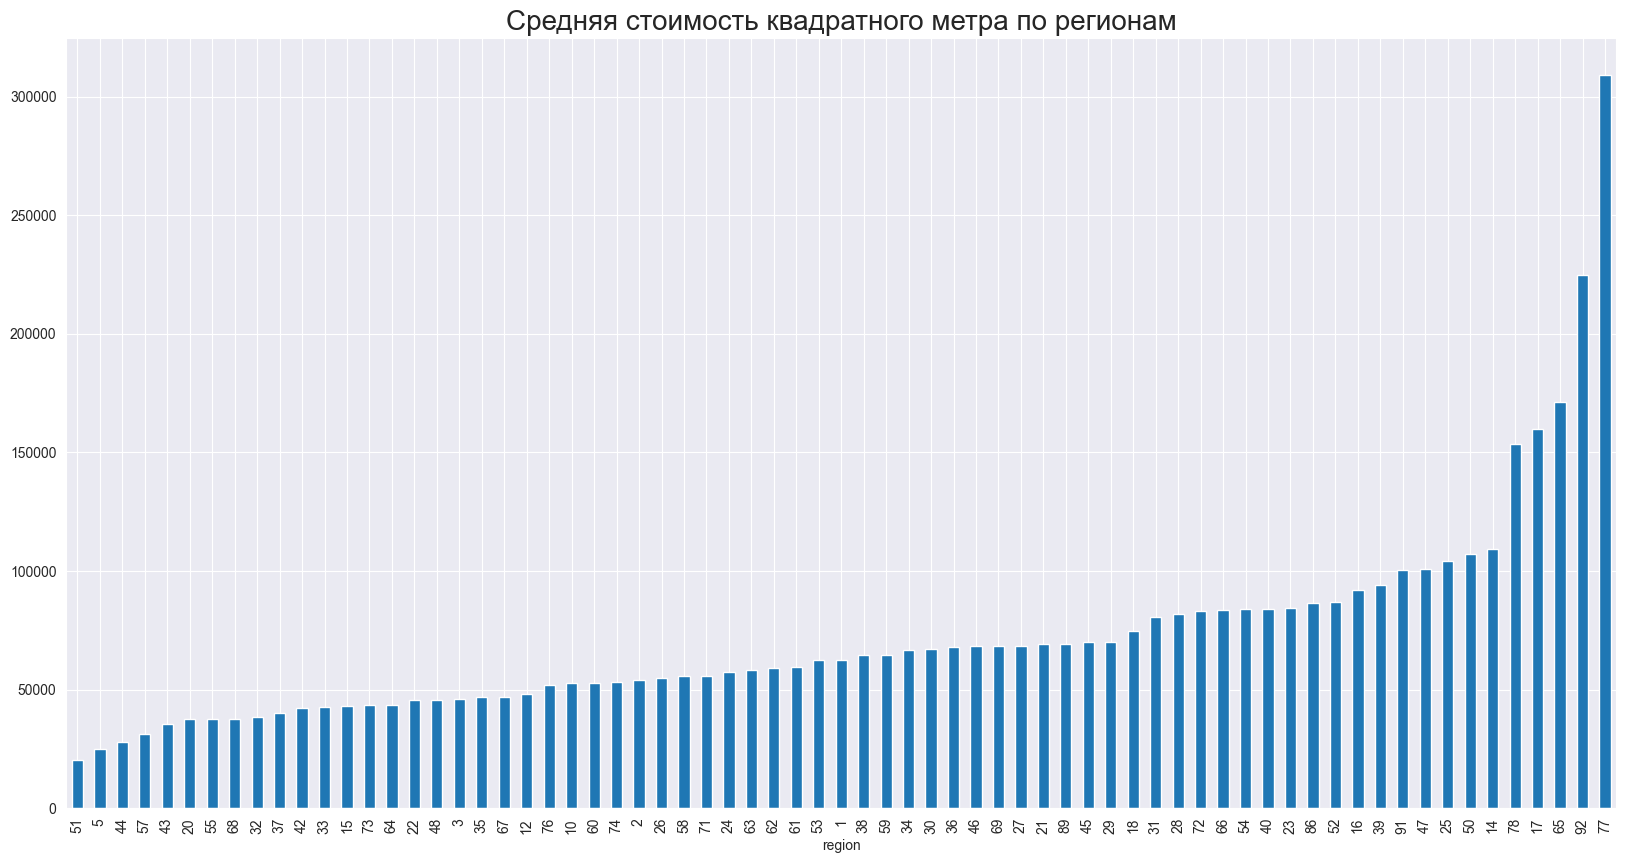

In [20]:
vis.get_bar('objPriceAvg', 'Средняя стоимость квадратного метра по регионам')

In [21]:
vis.table_ready()

objReady100PercDt 2017 2021  2022  2023  2024  2025 2026 2027 2028 2029 2030  \
region                                                                         
1                    -    -   9.0  13.0     -     -    -    -    -    -    -   
2                    -    -   4.0   2.0   3.0     -    -    -    -    -    -   
3                    -    -   1.0     -     -     -    -    -    -    -    -   
5                    -  3.0     -   5.0     -     -  1.0    -    -    -    -   
10                   -    -   3.0     -     -     -    -    -    -    -    -   
...                ...  ...   ...   ...   ...   ...  ...  ...  ...  ...  ...   
78                   -    -  68.0  68.0  51.0  16.0  1.0    -    -    -    -   
86                   -    -   3.0   4.0   1.0     -    -    -    -    -    -   
89                   -    -   6.0     -     -     -    -    -    -    -    -   
91                   -    -   9.0   4.0     -   3.0    -    -    -    -    -   
92                   -    -     -     - 

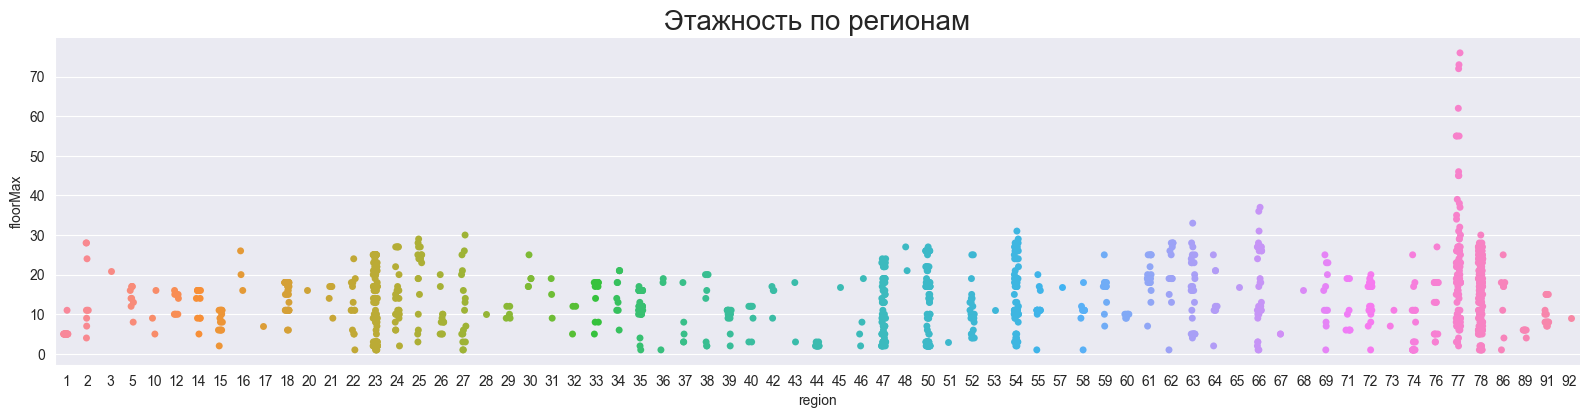

In [22]:
vis.cat_plot('floorMax', 'Этажность по регионам')

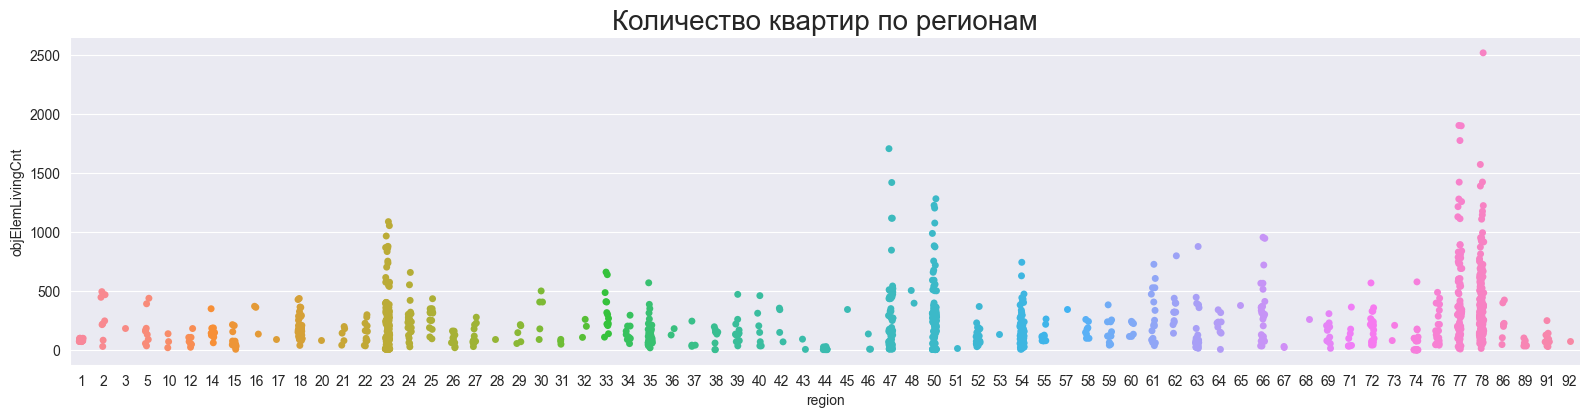

In [23]:
vis.cat_plot('objElemLivingCnt','Количество квартир по регионам')

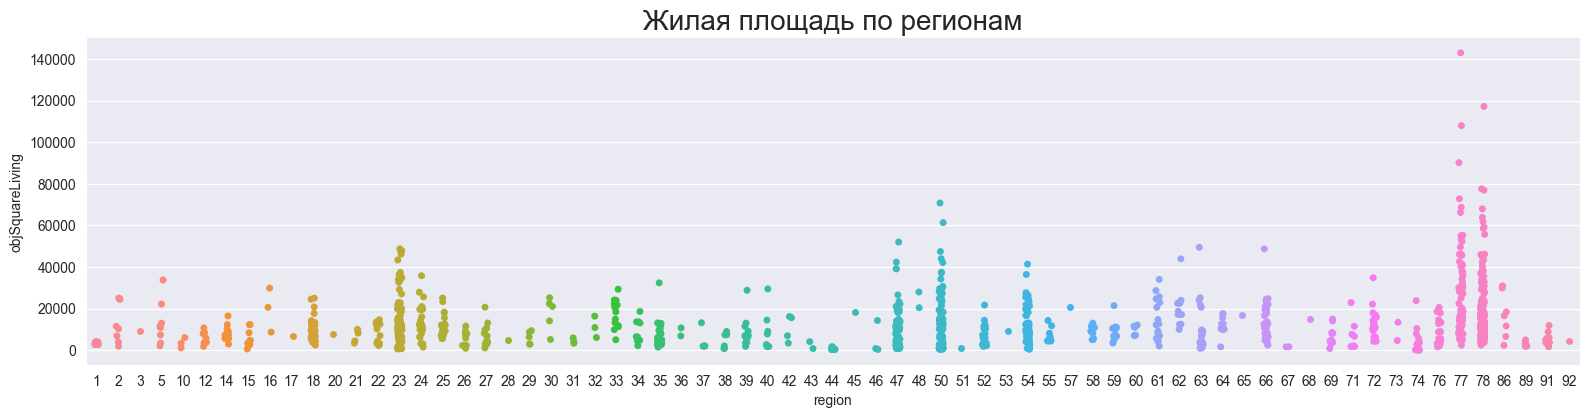

In [24]:
vis.cat_plot('objSquareLiving','Жилая площадь по регионам')

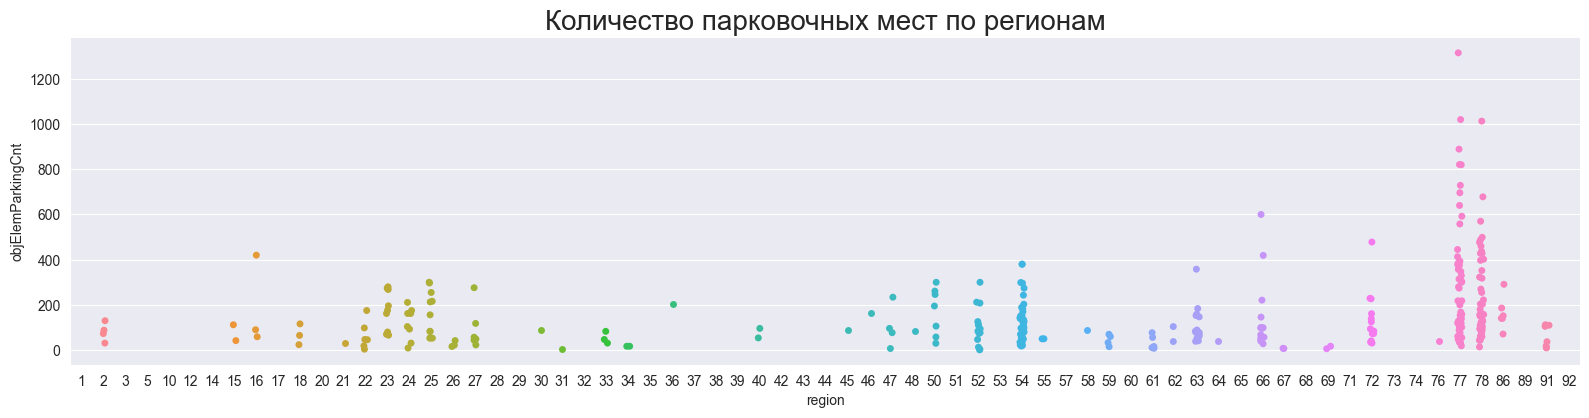

In [25]:
vis.cat_plot('objElemParkingCnt', 'Количество парковочных мест по регионам')

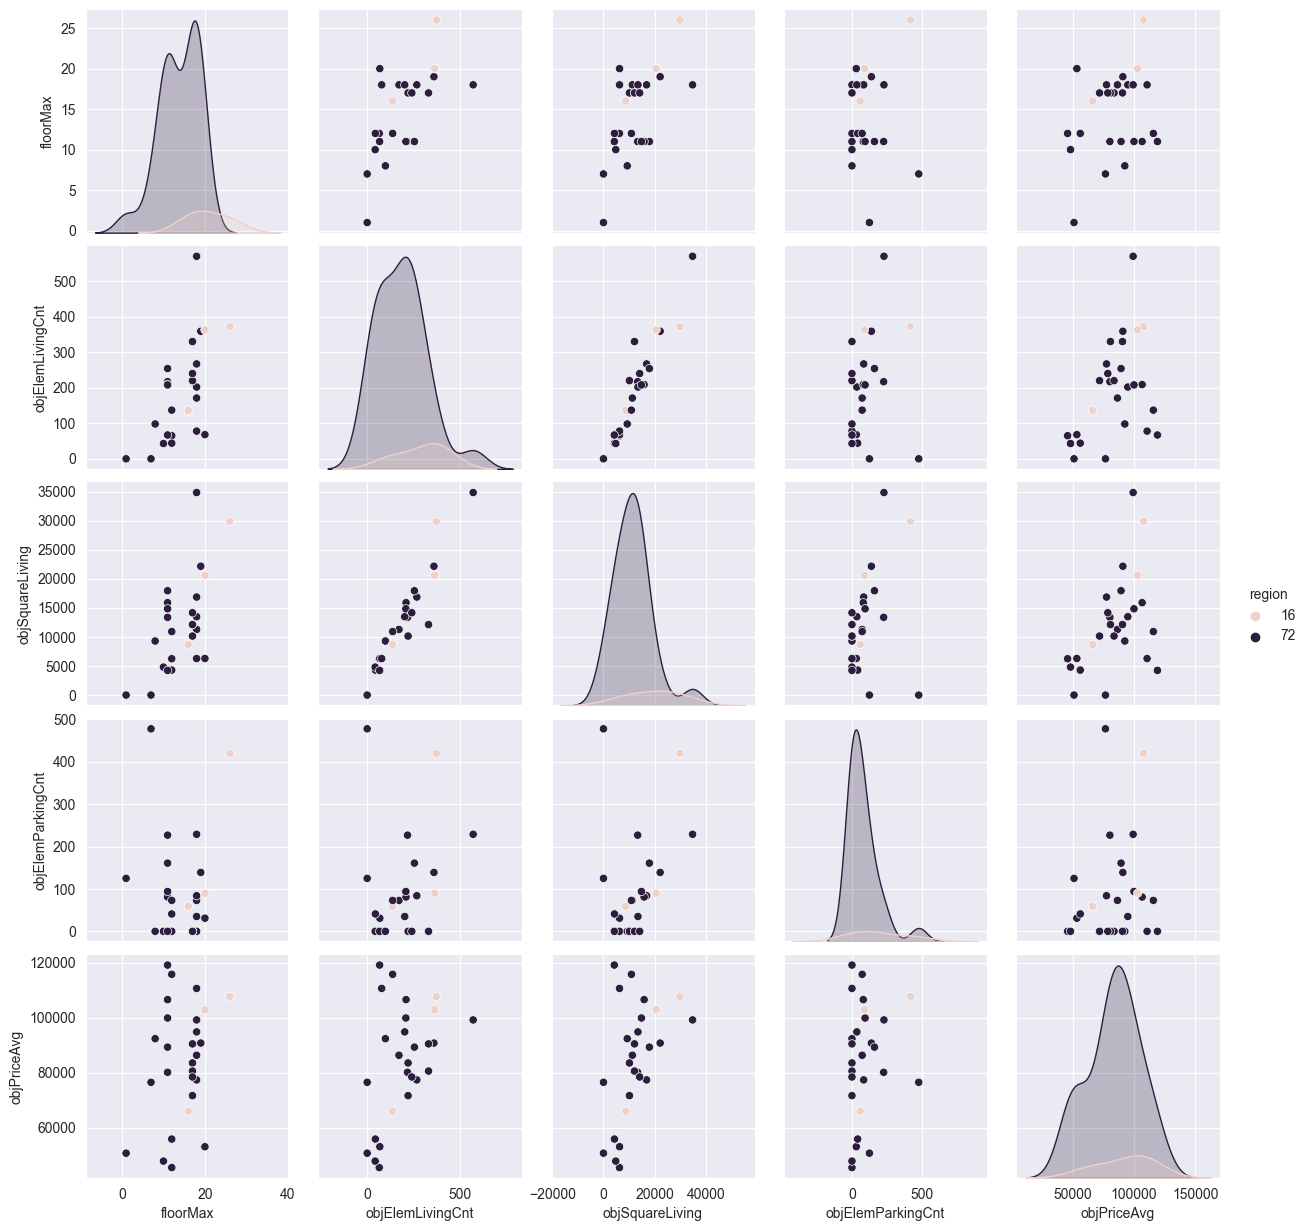

In [26]:
vis.corr()